In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
nPerClass = 1000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x, x)

widths = [1.8, 2.4]

images = torch.zeros(2*nPerClass, 1, imgSize, imgSize)
labels = torch.zeros(2*nPerClass)

for i in range(2*nPerClass):
    ro = 2*np.random.randn(2) # random offset
    G = np.exp( -( (X - ro[0])**2 + (Y - ro[1])**2 ) / (2*widths[i%2]**2) ) # formula for Gaussian

    G = G + np.random.randn(imgSize, imgSize)/5 # adding noise

    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)
    labels[i] = i%2

labels = labels[:, None]

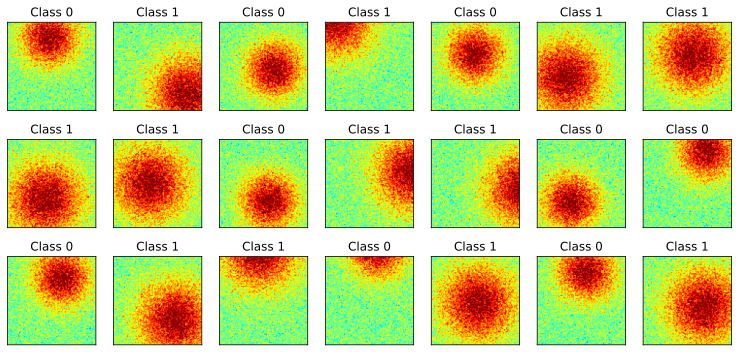

In [3]:
fig, axs = plt.subplots(3, 7, figsize = (13, 6))

for i, ax in enumerate(axs.flatten()):
    whichPic = np.random.randint(2*nPerClass)
    G = np.squeeze(images[whichPic, :, :])
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    ax.set_title('Class %s'%int(labels[whichPic].item()))
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, train_size=0.9)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1])


In [42]:
class Model(nn.Module):
    
   def __init__ (self, imgSize, conv1_in, conv1_out, conv2_out, kernal_size, stride, padding):
      super().__init__()

      def outputImageSize(imgSize, padding, kernal_size, stride):
         width = int(np.floor((((imgSize[0] + 2*padding[0] - kernal_size[0])/stride[0]) + 1)/2))
         height = int(np.floor((((imgSize[1] + 2*padding[1] - kernal_size[1])/stride[1]) + 1)/2))
         return width, height

      self.conv1 = nn.Conv2d(conv1_in, conv1_out, kernal_size, stride, padding)
      outputImageSize1 = outputImageSize(imgSize, padding, kernal_size, stride)
      # print(f'outputImageSize1: {outputImageSize1}')
      self.conv2 = nn.Conv2d(conv1_out, conv2_out, kernal_size, stride, padding)
      outputImageSize2 = outputImageSize(outputImageSize1, padding, kernal_size, stride)
      # print(f'outputImageSize2: {outputImageSize2}')
      self.fc1 = nn.Linear(conv2_out*outputImageSize2[0]*outputImageSize2[1], 50)
      self.output = nn.Linear(50, 1)

      # self.enc = nn.Sequential(
      #     nn.Conv2d(1, 6, 3, padding=1), # output image size = (91+2*1-3)/1 + 1 = 91
      #     nn.ReLU(),
      #     nn.AvgPool2d(2, 2),            # output image size = np.floor(91/2) = 45
      #     nn.Conv2d(6, 4, 3, padding=1), # output image size = (45+2*1-3)/1 + 1 = 45
      #     nn.ReLU(),
      #     nn.AvgPool2d(2, 2),            # output image size = np.floor(45/2) = 22
      #     nn.Flatten(),
      #     nn.Linear(4*22*22, 50),        # number of channels X height of image X width of image
      #     nn.Linear(50, 1)
      # )
    
   def forward(self, x):
      
      conv1out = F.relu(self.conv1(x))
      x = F.avg_pool2d(conv1out, (2, 2))

      conv2out = F.relu(self.conv2(x))
      x = F.avg_pool2d(conv2out, (2, 2))

   #    nUnits = x.shape.numel()/x.shape[0]
   #    x = x.view(-1, int(nUnits))
      x = x.reshape(x.shape[0], -1)
   #    print(f'Vectorize: {x.shape}')
      x = F.relu(self.fc1(x))
      x = self.output(x)

      return x, conv1out, conv2out

In [36]:
def getModel(imgSize, conv1_in, conv1_out, conv2_out, kernal_size, stride, padding):
    CNN = Model(imgSize, conv1_in, conv1_out, conv2_out, kernal_size, stride, padding)

    lossFunction = nn.BCEWithLogitsLoss()

    optimizer = torch.optim.Adam(CNN.parameters(), lr=0.001)

    return CNN, lossFunction, optimizer

In [41]:
# testing model

CNN, lossFunction, optimizer = getModel(imgSize=(91, 91), conv1_in=1, conv1_out=3, conv2_out=6, kernal_size=(3, 2), stride=(2, 3), padding=(1, 1))

X, y = next(iter(train_loader))
yHat, conv1out, conv2out = CNN(X)

# check sizes of model outputs and target variable
print(' ')
print(yHat.shape)
print(y.shape)

# now let's compute the loss
loss = lossFunction(yHat, y)
print(' ')
print('Loss:')
print(loss)


print(conv1out.shape)
print(conv2out.shape)



(91, 91) (1, 1) (3, 2) (2, 3)
(23, 15) (1, 1) (3, 2) (2, 3)
 
torch.Size([32, 1])
torch.Size([32, 1])
 
Loss:
tensor(0.7021, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
torch.Size([32, 3, 46, 31])
torch.Size([32, 6, 12, 6])


In [19]:
summary(CNN, (1, imgSize, imgSize))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 3, 46, 31]           21
├─Conv2d: 1-2                            [-1, 6, 12, 6]            114
├─Linear: 1-3                            [-1, 50]                  5,450
├─Linear: 1-4                            [-1, 1]                   51
Total params: 5,636
Trainable params: 5,636
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.03
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.09


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 3, 46, 31]           21
├─Conv2d: 1-2                            [-1, 6, 12, 6]            114
├─Linear: 1-3                            [-1, 50]                  5,450
├─Linear: 1-4                            [-1, 1]                   51
Total params: 5,636
Trainable params: 5,636
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.03
Forward/backward pass size (MB): 0.04
Params size (MB): 0.02
Estimated Total Size (MB): 0.09

In [20]:
def trainModel(CNN, lossFunction, optimizer):
    epochs = 10

    losses = torch.zeros(epochs)
    trainAcc = []
    testAcc = []

    for _ in range(epochs):

        CNN.train()
        batchAcc = []
        batchLoss = []
        for x, y in train_loader:
            yHat = CNN.forward(x)[0]
            
            loss = lossFunction(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(torch.mean(((yHat > 0.5) == y).float())*100)

        trainAcc.append(np.mean(batchAcc))
        losses[_] = np.mean(batchLoss)

        CNN.eval()
        X, Y = next(iter(test_loader))

        with torch.no_grad():
            pred = CNN(X)[0]

        testAcc.append(torch.mean(((pred > 0.5)==Y).float())*100)

    return trainAcc, testAcc, losses, CNN

In [43]:
imgSize=(91, 91)
conv1_in=1
conv1_out=3
conv2_out=6
kernal_size=(3, 2)
stride=(2, 3)
padding=(1, 1)

CNN, lossFunction, optimizer = getModel(imgSize, conv1_in, conv1_out, conv2_out, kernal_size, stride, padding)
trainAcc, testAcc, losses, CNN = trainModel(CNN, lossFunction, optimizer)

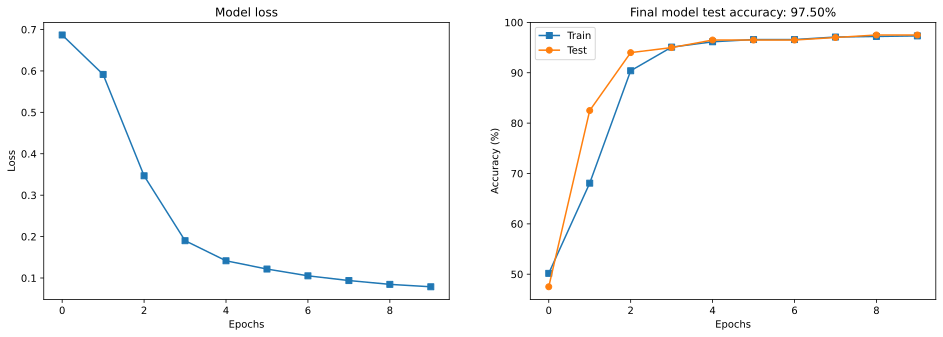

In [44]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses,'s-')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

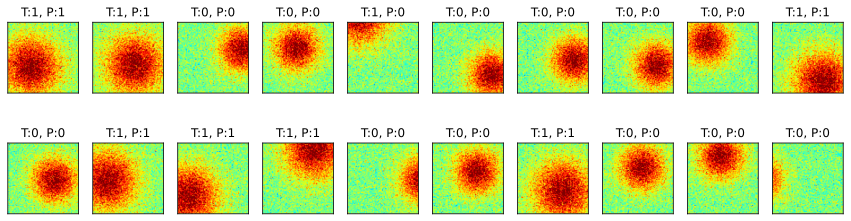

In [45]:
# visualize some images

X, y = next(iter(test_loader))
yHat, featuremap1, featuremap2 = CNN(X)

fig, axs = plt.subplots(2, 10, figsize = (15, 4))

for i, ax in enumerate(axs.flatten()):
    G = torch.squeeze(X[i, :, :]).detach()
    ax.imshow(G, vmin=-1, vmax=1, cmap='jet')
    t = ( int(y[i].item()), int(yHat[i].item()>0.5))
    ax.set_title('T:%s, P:%s'%t)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

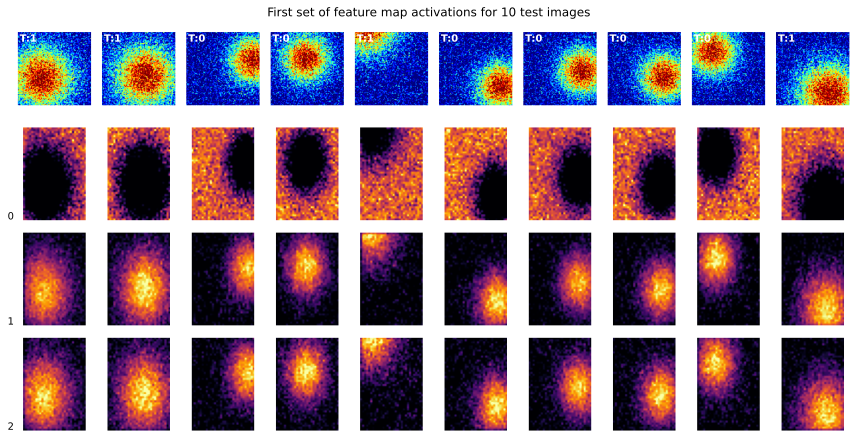

In [46]:
# Feature maps from the conv1 layer

fig,axs = plt.subplots(conv1_out+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')
  axs[0,pici].text(2,2,'T:%s'%int(y[pici].item()),ha='left',va='top',color='w',fontweight='bold')

  for feati in range(conv1_out):
    # extract the feature map from this image
    img = featuremap1[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,45,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('First set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()

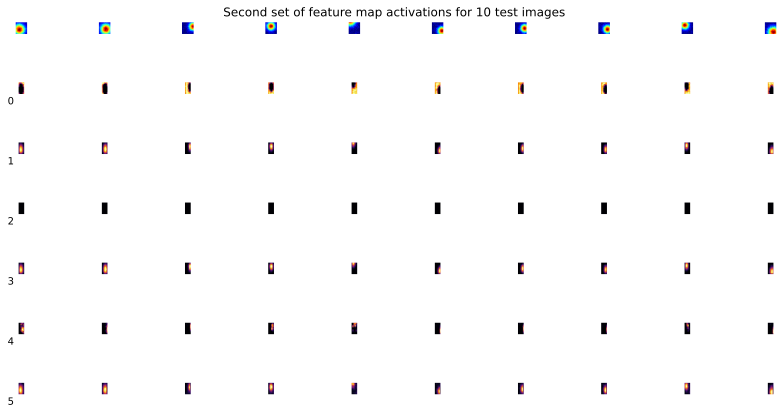

In [47]:
# Repeat for feature2 maps

fig,axs = plt.subplots(conv2_out+1,10,figsize=(12,6))

for pici in range(10):

  # show the original picture
  img = X[pici,0,:,:].detach()
  axs[0,pici].imshow(img,cmap='jet',vmin=0,vmax=1)
  axs[0,pici].axis('off')

  for feati in range(conv2_out):
    # extract the feature map from this image
    img = featuremap2[pici,feati,:,:].detach()
    axs[feati+1,pici].imshow(img,cmap='inferno',vmin=0,vmax=torch.max(img)*.9)
    axs[feati+1,pici].axis('off')
    axs[feati+1,pici].text(-5,22,feati,ha='right') if pici==0 else None

plt.tight_layout()
plt.suptitle('Second set of feature map activations for 10 test images',x=.5,y=1.01)
plt.show()